# Mask R-CNN Demo

A quick intro to using the pre-trained model to detect and segment objects.

In [63]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "images")

In [64]:
fileName = "Best.jpeg"

In [65]:
import torchvision
import cv2

# create a model object from the keypointrcnn_resnet50_fpn class
model = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True)
# call the eval() method to prepare the model for inference mode.
model.eval()

# create the list of keypoints.
keypoints = ['nose','left_eye','right_eye',\
'left_ear','right_ear','left_shoulder',\
'right_shoulder','left_elbow','right_elbow',\
'left_wrist','right_wrist','left_hip',\
'right_hip','left_knee', 'right_knee', \
'left_ankle','right_ankle']

In [66]:
# import the transforms module
from torchvision import transforms as T

# Read the image using opencv 
img_path = os.path.join(IMAGE_DIR, fileName)
img = cv2.imread(img_path)

# preprocess the input image
transform = T.Compose([T.ToTensor()])
img_tensor = transform(img)

# forward-pass the model
# the input is a list, hence the output will also be a list
output = model([img_tensor])[0]


In [67]:
# import the transforms module
import cv2
from torchvision import transforms as T

# Read the image using opencv

img_path = os.path.join(IMAGE_DIR, fileName)

img = cv2.imread(img_path)

# preprocess the input image

transform = T.Compose([T.ToTensor()])
img_tensor = transform(img)

# forward-pass the model
# the input is a list, hence the output will also be a list

output = model([img_tensor])[0]

In [68]:
import matplotlib.pyplot as plt

def draw_keypoints_per_person(img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9):
    # initialize a set of colors from the rainbow spectrum
    cmap = plt.get_cmap('rainbow')
    # create a copy of the image
    img_copy = img.copy()
    # pick a set of N color-ids from the spectrum
    color_id = np.arange(1,255, 255//len(all_keypoints)).tolist()[::-1]
    # iterate for every person detected
    for person_id in range(len(all_keypoints)):
      # check the confidence score of the detected person
      if confs[person_id]>conf_threshold:
        # grab the keypoint-locations for the detected person
        keypoints = all_keypoints[person_id, ...]
        # grab the keypoint-scores for the keypoints
        scores = all_scores[person_id, ...]
        print(scores)
        # iterate for every keypoint-score
        for kp in range(len(scores)):
            # check the confidence score of detected keypoint
            if scores[kp]>keypoint_threshold:
                # convert the keypoint float-array to a python-list of integers
                keypoint = tuple(map(int, keypoints[kp, :2].detach().numpy().tolist()))
                # pick the color at the specific color-id
                color = tuple(np.asarray(cmap(color_id[person_id])[:-1])*255)
                # draw a circle over the keypoint location
                cv2.circle(img_copy, keypoint, 30, color, -1)

    return img_copy

In [69]:
keypoints_img = draw_keypoints_per_person(img, output["keypoints"], output["keypoints_scores"], output["scores"], keypoint_threshold=0.5)

tensor([13.9142, 13.9917, 13.0618, 12.5989, 10.6522,  7.6078,  7.5891,  4.4572,
         2.3289,  1.5857,  1.3650,  7.4994,  8.5495,  9.2144,  8.2848,  6.5047,
         8.6724], grad_fn=<SelectBackward0>)
tensor([13.5114, 13.8469, 14.8400, 14.5182, 10.1633,  8.4213,  8.5605,  7.8295,
         2.4403, 11.5083,  0.1247,  8.3661,  8.7550,  9.5973, 10.0273,  6.8067,
         7.6182], grad_fn=<SelectBackward0>)
tensor([12.9014, 12.9538, 13.5425, 12.1165, 12.7740,  7.5094,  8.2062,  8.3173,
         6.5517,  9.5504,  7.5164,  6.9680,  4.3551,  6.9603,  8.3797,  2.9029,
         6.1260], grad_fn=<SelectBackward0>)
tensor([13.3636, 13.3853, 13.4080, 12.2238, 11.0088,  7.9943,  5.6635,  6.5209,
         2.1060,  6.7945,  2.2932,  6.0511,  5.4755,  4.5370,  7.2871,  2.9083,
         3.5807], grad_fn=<SelectBackward0>)
tensor([11.5560, 11.2387, 11.5543,  8.3927, 11.0653,  3.4240,  5.6745, -1.4305,
         1.3519, -1.6324, -0.0837, -2.0044, -2.2874, -2.7332, -0.4476, -2.8777,
        -3.1340], gr

In [70]:
def get_limbs_from_keypoints(keypoints):
  limbs = [       
        [keypoints.index('right_eye'), keypoints.index('nose')],
        [keypoints.index('right_eye'), keypoints.index('right_ear')],
        [keypoints.index('left_eye'), keypoints.index('nose')],
        [keypoints.index('left_eye'), keypoints.index('left_ear')],
        [keypoints.index('right_shoulder'), keypoints.index('right_elbow')],
        [keypoints.index('right_elbow'), keypoints.index('right_wrist')],
        [keypoints.index('left_shoulder'), keypoints.index('left_elbow')],
        [keypoints.index('left_elbow'), keypoints.index('left_wrist')],
        [keypoints.index('right_hip'), keypoints.index('right_knee')],
        [keypoints.index('right_knee'), keypoints.index('right_ankle')],
        [keypoints.index('left_hip'), keypoints.index('left_knee')],
        [keypoints.index('left_knee'), keypoints.index('left_ankle')],
        [keypoints.index('right_shoulder'), keypoints.index('left_shoulder')],
        [keypoints.index('right_hip'), keypoints.index('left_hip')],
        [keypoints.index('right_shoulder'), keypoints.index('right_hip')],
        [keypoints.index('left_shoulder'), keypoints.index('left_hip')]
        ]
  return limbs

limbs = get_limbs_from_keypoints(keypoints)

In [71]:
def draw_skeleton_per_person(img, all_keypoints, all_scores, confs, keypoint_threshold=2, conf_threshold=0.9):
    
    # initialize a set of colors from the rainbow spectrum
    cmap = plt.get_cmap('rainbow')
    # create a copy of the image
    img_copy = img.copy()
    # check if the keypoints are detected
    if len(output["keypoints"])>0:
      # pick a set of N color-ids from the spectrum
      colors = np.arange(1,255, 255//len(all_keypoints)).tolist()[::-1]
      # iterate for every person detected
      for person_id in range(len(all_keypoints)):
          # check the confidence score of the detected person
          if confs[person_id]>conf_threshold:
            # grab the keypoint-locations for the detected person
            keypoints = all_keypoints[person_id, ...]

            # iterate for every limb 
            for limb_id in range(len(limbs)):
              # pick the start-point of the limb
              limb_loc1 = keypoints[limbs[limb_id][0], :2].detach().numpy().astype(np.int32)
              # pick the start-point of the limb
              limb_loc2 = keypoints[limbs[limb_id][1], :2].detach().numpy().astype(np.int32)
              # consider limb-confidence score as the minimum keypoint score among the two keypoint scores
              limb_score = min(all_scores[person_id, limbs[limb_id][0]], all_scores[person_id, limbs[limb_id][1]])
              # check if limb-score is greater than threshold
              if limb_score> keypoint_threshold:
                # pick the color at a specific color-id
                color = tuple(np.asarray(cmap(colors[person_id])[:-1])*255)
                # draw the line for the limb
                cv2.line(img_copy, tuple(limb_loc1), tuple(limb_loc2), color, 5)

    return img_copy

In [72]:
# overlay the skeleton in the detected person
skeletal_img = draw_skeleton_per_person(img, output["keypoints"], output["keypoints_scores"], output["scores"],keypoint_threshold=2)

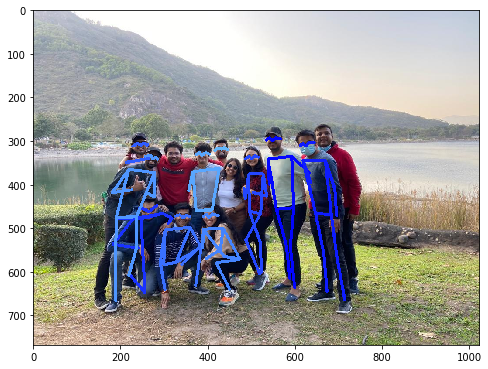

In [73]:
rgb_img = cv2.cvtColor(skeletal_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (8,10))
plt.imshow(rgb_img)
plt.show()

## Configurations

We'll be using a model trained on the MS-COCO dataset. The configurations of this model are in the ```CocoConfig``` class in ```coco.py```.

For inferencing, modify the configurations a bit to fit the task. To do so, sub-class the ```CocoConfig``` class and override the attributes you need to change.

In [59]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                93
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Create Model and Load Trained Weights

In [60]:
# Create model object in inference mode.
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

# Load weights trained on MS-COCO
model.load_weights(COCO_MODEL_PATH, by_name=True)

In [61]:
# COCO Class names
# Index of the class in the list is its ID. For example, to get ID of
# the teddy bear class, use: class_names.index('teddy bear')
class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

## Run Object Detection

Processing 1 images
image                    shape: (1280, 958, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 93)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


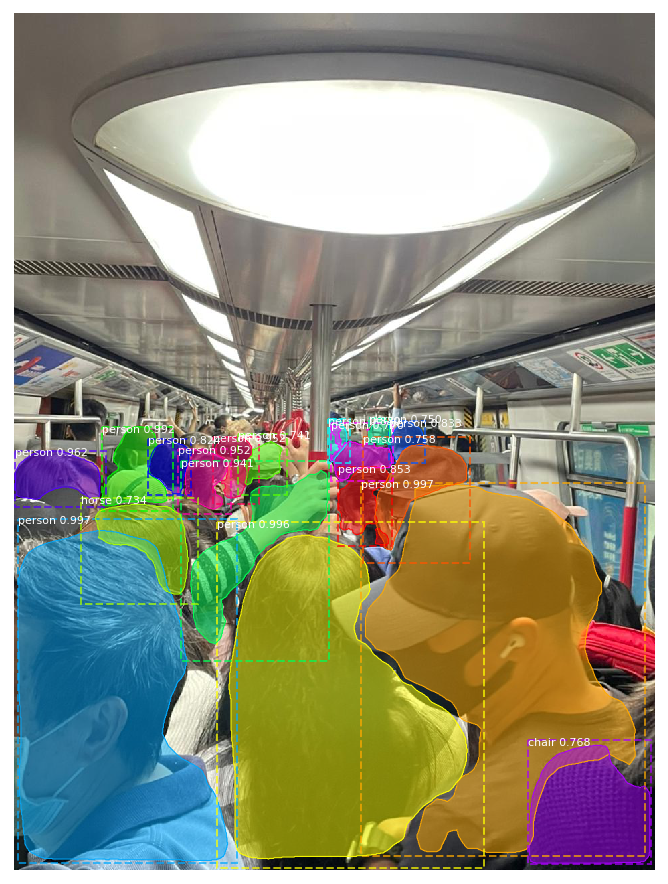

In [62]:
# Load a random image from the images folder
file_names = next(os.walk(IMAGE_DIR))[2]
image = skimage.io.imread(os.path.join(IMAGE_DIR, fileName))

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
# visualize.display_keypoints(image,r['rois'],r['keypoints'],r['class_ids'],class_names, skeleton = config.LIMBS)
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            class_names, r['scores'])